In [16]:
from typing import List, Dict

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import *
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import itertools

from dcurves import dca, plot_graphs


In [17]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)

In [18]:

processed_data = convert_numeric_to_float16(processed_data)

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

In [19]:
cv_analytics_utils: Dict[str, CvAnalyticsUtil] = {}

In [20]:

# https://xgboost.readthedocs.io/en/latest/parameter.html
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier_entropy': RandomForestClassifier(criterion= 'entropy', n_estimators= 200), # Best one
    'RandomForestClassifier': RandomForestClassifier(criterion='entropy', n_estimators=300), # Best one
    # 'RandomForestClassifier_log_loss': RandomForestClassifier(criterion= 'log_loss', n_estimators= 300),
    # 'RandomForestClassifier_gini': RandomForestClassifier(criterion= 'gini', n_estimators= 300),
    # 'XGBClassifier_error': XGBClassifier(eval_metric= 'error', learning_rate=0.1),
    'XGBClassifier': XGBClassifier(eval_metric= 'logloss', learning_rate=0.1), # Best one
    # 'XGBClassifier_rmsle': XGBClassifier(objective='binary:logistic', eval_metric= 'rmsle', learning_rate=0.1),
    # 'XGBClassifier_rmse': XGBClassifier(objective='binary:logistic', eval_metric= 'rmse', learning_rate=0.1),
    # 'XGBClassifier_mae': XGBClassifier(objective='binary:logistic', eval_metric= 'mae', learning_rate=0.1),
    # 'XGBClassifier_mape': XGBClassifier(objective='binary:logistic', eval_metric= 'mape', learning_rate=0.1),
    # 'XGBClassifier_aucpr': XGBClassifier(eval_metric= 'aucpr', learning_rate=0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    ExperimentDataHelperSingleLabelScreenedFirst5,    
    # ExperimentDataHelperScreenedFirst5,
    # ExperimentDataHelperNotScreenedColsFirst5,
    # ExperimentDataHelperScreenedColsFirst5,
    # ExperimentDataHelperScreenedOrCancer,
    # ExperimentDataHelperScreened,
    # ExperimentDataHelperNotScreenedCols,
    # ExperimentDataHelperScreenedCols,
    # ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll,
    # ExperimentDataHelperScreenedFirst5ca125AndBinary,
    # ExperimentDataHelperScreenedFirst5ca125Binary, 
    # ExperimentDataHelperScreenedFirst5ca125AndBinaryNoResult,
]

In [21]:
years = [1]
num_folds=15
test_n_folds=15
train_size = 25000
# [None, 25, 35, 50, 75, 100]
top_k_features = [50]
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            for top_k in top_k_features:
                if year:
                    label = f'cancer_in_next_{year}_years'
                else: 
                    label = 'ovar_cancer'
                filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_{label}__{num_folds}_trials'
                select_cols = None
                if top_k:
                    select_cols = feature_importance_reader(filesuffix)[:top_k]
                    filesuffix = f'_for_experiment_{experiment_data_helper_class.get_name()}_top_{top_k}_features_{classifier_name}_{label}__{num_folds}_trials'
                print(filesuffix)
                # print(select_cols)
                experiment_data_helper: ExperimentDataHelper = experiment_data_helper_class(processed_data, label, ['cancer_'], train_size = train_size, select_features=select_cols)
                # experiment_data_helper.set_train_size_to_max(num_folds)
                experiment_runner = ExperimentRunner(classifier, experiment_data_helper, num_folds=num_folds, test_n_folds=test_n_folds)
                cv_analytics_util = experiment_runner.run_experiment()
                cv_analytics_utils[filesuffix] = cv_analytics_util
                cv_analytics_util.store_cv_analytics_utils(filesuffix)


_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials
_for_experiment_not_screened_cols_single_label_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials
_for_experiment_participants_screened_single_first_5_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials
_for_experiment_not_screened_cols_single_label_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials


In [22]:
sorted_df = experiment_data_helper.source_df.sort_values(by=['plco_id'])

In [23]:
def find_different_cols(df):
    return df.columns[df.nunique() > 1]

def extract_subrecords(plco_id):
    df = sorted_df[sorted_df['plco_id'].isin([plco_id])]
    return df[find_different_cols(df)]

In [24]:
plco_ids = ['A-001979-6', 'A-002879-7']

print_df(extract_subrecords(plco_ids[0]))

+--------+---------+---------------------+-------+------------+
|        |   index |   ovar_observe_year |   age |   study_yr |
|--------+---------+---------------------+-------+------------|
| 307801 |  307801 |                   8 |    65 |         -1 |
| 227729 |  227729 |                   5 |    60 |          5 |
| 190719 |  190719 |                   4 |    60 |          4 |
|      3 |       3 |                   0 |    55 |          0 |
| 264704 |  264704 |                   6 |    60 |         -1 |
| 153633 |  153633 |                   3 |    60 |          3 |
|  78211 |   78211 |                   1 |    55 |          1 |
| 643696 |  643696 |                  18 |    75 |         -1 |
| 116202 |  116202 |                   2 |    55 |          2 |
| 444114 |  444114 |                  13 |    70 |         -1 |
+--------+---------+---------------------+-------+------------+


In [25]:
experiment_data_helper.source_df

,hyster_f,brothers,liver_comorbidity,hispanic_f,index,ovary_trial_flag,ovariesr_f,plco_id,gallblad_f,race7,...,livec,was_screened,ph_any_not_ovar_bq,ovarsumm_fh_cnt,ovar_observe_year,colon_comorbidity,stillb,age,bronchit_f,study_yr
0,1.0,0.0,0.0,0.0,0,1.0,0.0,A-001799-8,0.0,1.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,-1.0
1,0.0,0.0,0.0,0.0,1,1.0,0.0,A-001889-7,0.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,-1.0
2,0.0,2.0,1.0,0.0,2,1.0,0.0,A-001898-8,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,-1.0
3,0.0,2.0,0.0,0.0,3,1.0,0.0,A-001979-6,0.0,4.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0
4,1.0,4.0,0.0,0.0,4,1.0,2.0,A-002699-9,0.0,1.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658779,0.0,3.0,0.0,0.0,658779,1.0,0.0,Z-161674-9,0.0,1.0,...,4.0,0.0,0.0,0.0,18.0,0.0,0.0,85.0,0.0,-1.0
658780,1.0,0.0,1.0,0.0,658780,0.0,4.0,Z-161683-0,0.0,1.0,...,4.0,0.0,0.0,0.0,18.0,0.0,0.0,80.0,0.0,-1.0
658781,1.0,3.0,0.0,0.0,658781,0.0,4.0,Z-161728-4,0.0,1.0,...,5.0,0.0,0.0,0.0,18.0,0.0,0.0,80.0,0.0,-1.0
658782,1.0,4.0,0.0,0.0,658782,1.0,0.0,Z-162367-9,0.0,1.0,...,4.0,0.0,0.0,0.0,18.0,0.0,0.0,80.0,0.0,-1.0


In [26]:
for analytics_util in cv_analytics_util.analytics_utils: 
    print(analytics_util.get_report_generation_util().get_roc_threshold())

0.09073464572429657
0.35320407152175903
0.2023247629404068
0.027708495035767555
0.16042481362819672
0.19653604924678802
0.3168698251247406
0.18878401815891266
0.3337984085083008
0.3350568413734436
0.1795232594013214
0.5088431239128113
0.2643190026283264
0.06768840551376343
0.6211619973182678


In [27]:
# for key, cv_analytics_util in cv_analytics_utils.items():
#     print(f"{key}: ")
#     filepath = f'./trees/decision_tree_for_{key}.png'
#     cv_analytics_util.analytics_utils[0].plot_save_tree(False, filepath)

In [28]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    cv_analytics_util.store_cv_results()

_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials: 


Cross-Validation measures:
+--------------------+----------+-------------+----------+----------+
|                    |     mean |         std |      min |      max |
|--------------------+----------+-------------+----------+----------|
| precision__class_0 | 0.999516 | 9.89075e-05 | 0.999295 | 0.999646 |
| recall__class_0    | 0.999551 | 0.000273244 | 0.998936 | 0.999911 |
| f1-score__class_0  | 0.999533 | 0.000127544 | 0.999291 | 0.999778 |
| precision__class_1 | 0.410224 | 0.146601    | 0.25     | 0.833333 |
| recall__class_1    | 0.359259 | 0.122873    | 0.111111 | 0.555556 |
| f1-score__class_1  | 0.365847 | 0.111057    | 0.166667 | 0.666667 |
| accuracy           | 0.999067 | 0.000254757 | 0.998583 | 0.999557 |
| auc                | 0.923036 | 0.0580915   | 0.828073 | 0.997988 |
+--------------------+----------+-------------+----------+----------+
_fo

_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials: 


Cross-Validation measures:
+--------------------+----------+-------------+----------+----------+
|                    |     mean |         std |      min |      max |
|--------------------+----------+-------------+----------+----------|
| precision__class_0 | 0.999516 | 9.89075e-05 | 0.999295 | 0.999646 |
| recall__class_0    | 0.999551 | 0.000273244 | 0.998936 | 0.999911 |
| f1-score__class_0  | 0.999533 | 0.000127544 | 0.999291 | 0.999778 |
| precision__class_1 | 0.410224 | 0.146601    | 0.25     | 0.833333 |
| recall__class_1    | 0.359259 | 0.122873    | 0.111111 | 0.555556 |
| f1-score__class_1  | 0.365847 | 0.111057    | 0.166667 | 0.666667 |
| accuracy           | 0.999067 | 0.000254757 | 0.998583 | 0.999557 |
| auc                | 0.923036 | 0.0580915   | 0.828073 | 0.997988 |
+--------------------+----------+-------------+----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


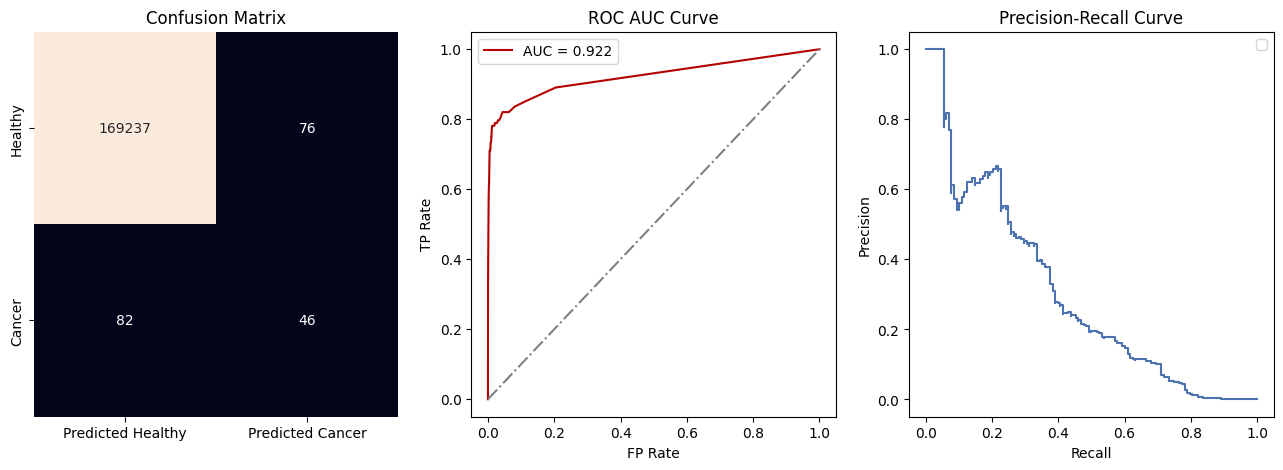

_for_experiment_not_screened_cols_single_label_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials: 


Cross-Validation measures:
+--------------------+------------+------------+----------+------------+
|                    |       mean |        std |      min |        max |
|--------------------+------------+------------+----------+------------|
| precision__class_0 | 0.998715   | 1.9915e-05 | 0.99869  | 0.998757   |
| recall__class_0    | 0.988933   | 0.0022783  | 0.985463 | 0.992226   |
| f1-score__class_0  | 0.993799   | 0.00115064 | 0.992032 | 0.995448   |
| precision__class_1 | 0.00157141 | 0.00195247 | 0        | 0.00615385 |
| recall__class_1    | 0.0130081  | 0.0156083  | 0        | 0.0487805  |
| f1-score__class_1  | 0.00279618 | 0.00345926 | 0        | 0.010929   |
| accuracy           | 0.987676   | 0.00227192 | 0.98419  | 0.990937   |
| auc                | 0.551168   | 0.0611245  | 0.449553 | 0.656184   |
+--------------------+------------+-----------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


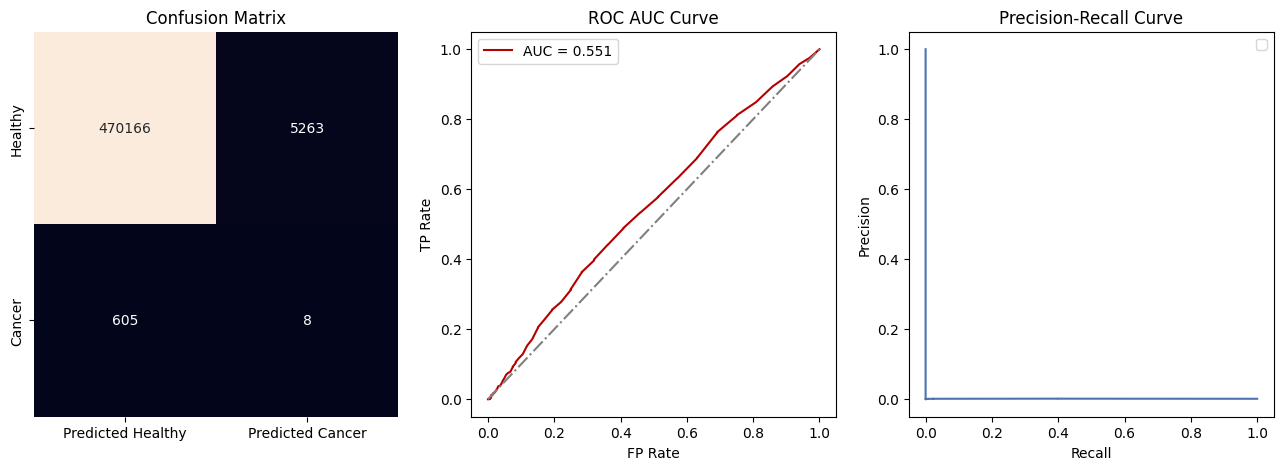

_for_experiment_participants_screened_single_first_5_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials: 


Cross-Validation measures:
+--------------------+----------+-------------+-----------+----------+
|                    |     mean |         std |       min |      max |
|--------------------+----------+-------------+-----------+----------|
| precision__class_0 | 0.999668 | 0.0001133   | 0.999468  | 0.999822 |
| recall__class_0    | 0.996899 | 0.000819022 | 0.995303  | 0.998848 |
| f1-score__class_0  | 0.998282 | 0.000407319 | 0.997424  | 0.999158 |
| precision__class_1 | 0.126468 | 0.0398228   | 0.0535714 | 0.1875   |
| recall__class_1    | 0.562037 | 0.147628    | 0.333333  | 0.777778 |
| f1-score__class_1  | 0.20356  | 0.0575196   | 0.09375   | 0.297872 |
| accuracy           | 0.996571 | 0.00081161  | 0.994863  | 0.998318 |
| auc                | 0.9564   | 0.033736    | 0.891908  | 0.996869 |
+--------------------+----------+-------------+-----------+----------+


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


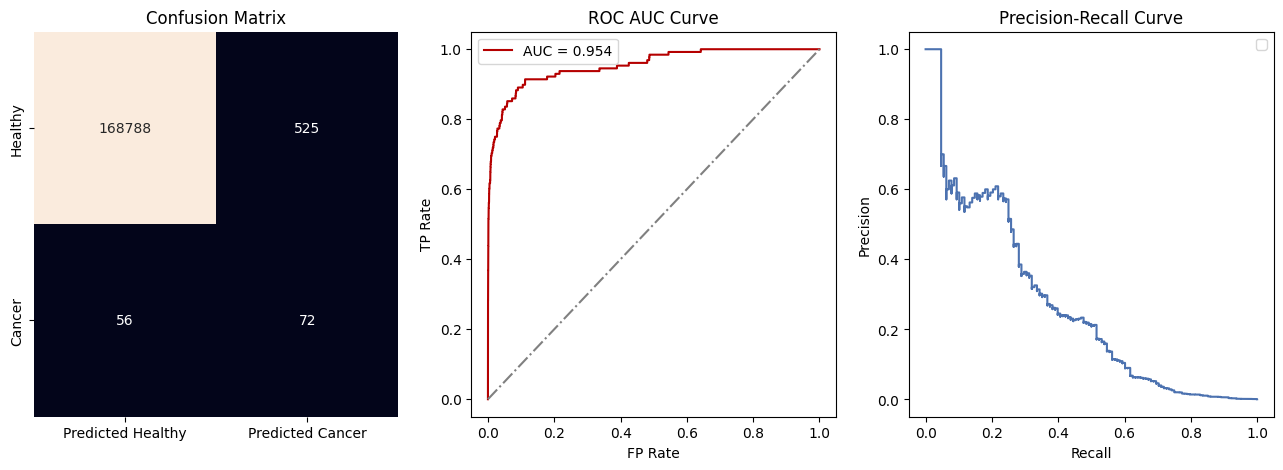

_for_experiment_not_screened_cols_single_label_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials: 


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.998825   | 0.000139166 | 0.998638   | 0.999038   |
| recall__class_0    | 0.852963   | 0.00845517  | 0.840339   | 0.8726     |
| f1-score__class_0  | 0.920129   | 0.00493152  | 0.912789   | 0.931528   |
| precision__class_1 | 0.00196294 | 0.000870305 | 0.00080016 | 0.00332742 |
| recall__class_1    | 0.221545   | 0.0928818   | 0.097561   | 0.365854   |
| f1-score__class_1  | 0.00389126 | 0.00172426  | 0.00158762 | 0.00659486 |
| accuracy           | 0.852151   | 0.00848083  | 0.83963    | 0.871884   |
| auc                | 0.585291   | 0.0787473   | 0.449998   | 0.687778   |
+--------------------+

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


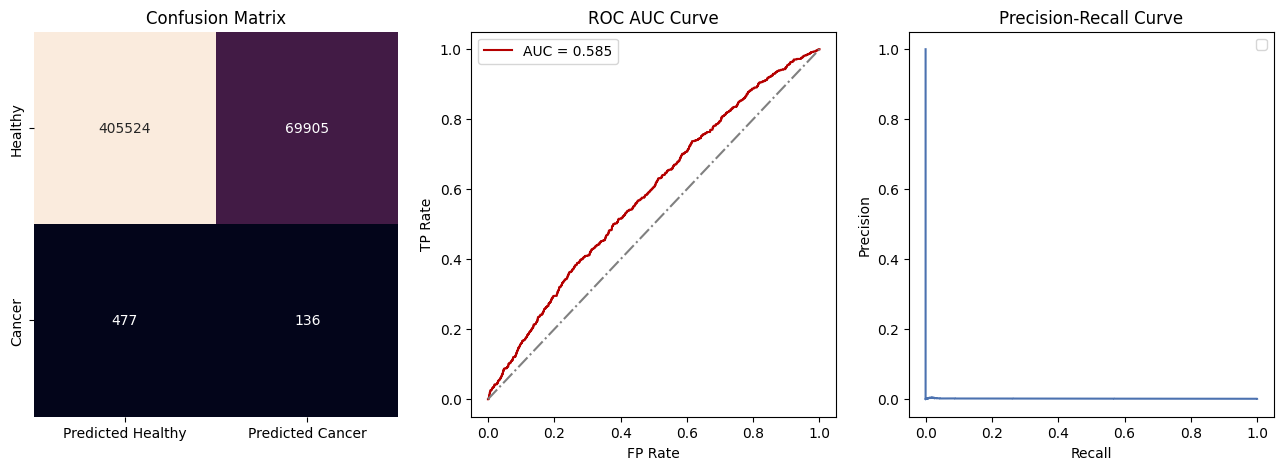

In [29]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    cv_analytics_util.update_thresholds(None)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()

_for_experiment_participants_screened_single_first_5_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials: 
Threshold: 0.02


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+----------+
|                    |      mean |         std |       min |      max |
|--------------------+-----------+-------------+-----------+----------|
| precision__class_0 | 0.999786  | 9.40812e-05 | 0.999642  | 1        |
| recall__class_0    | 0.992261  | 0.0015197   | 0.989301  | 0.99427  |
| f1-score__class_0  | 0.996008  | 0.000764313 | 0.994488  | 0.996995 |
| precision__class_1 | 0.0673847 | 0.0155452   | 0.037037  | 0.084507 |
| recall__class_1    | 0.717593  | 0.128228    | 0.5       | 1        |
| f1-score__class_1  | 0.12289   | 0.0272786   | 0.0689655 | 0.15     |
| accuracy           | 0.992054  | 0.00151507  | 0.989041  | 0.99401  |
| auc                | 0.923036  | 0.0580915   | 0.828073  | 0.997988 |
+--------------------+-----------+-

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


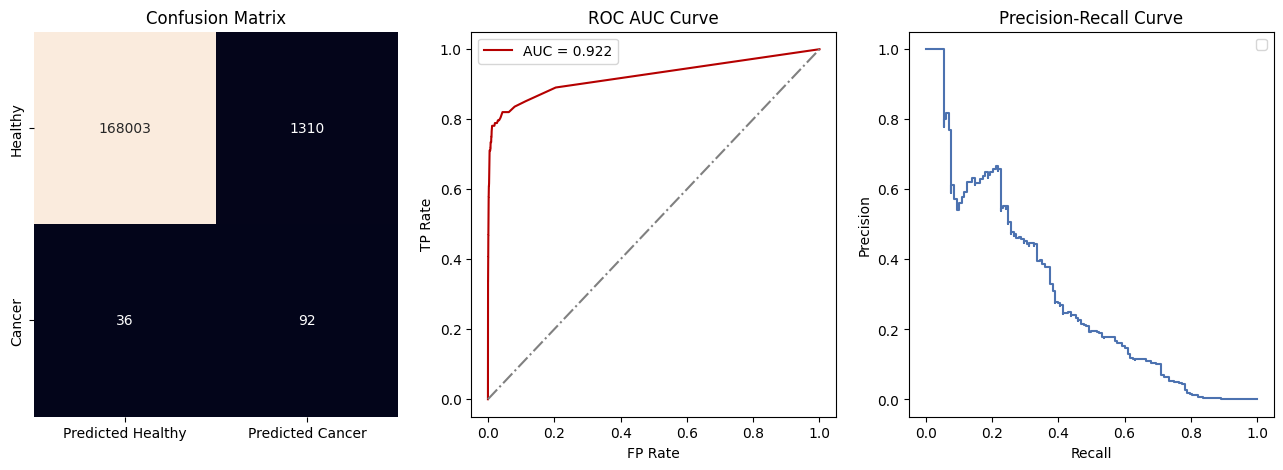

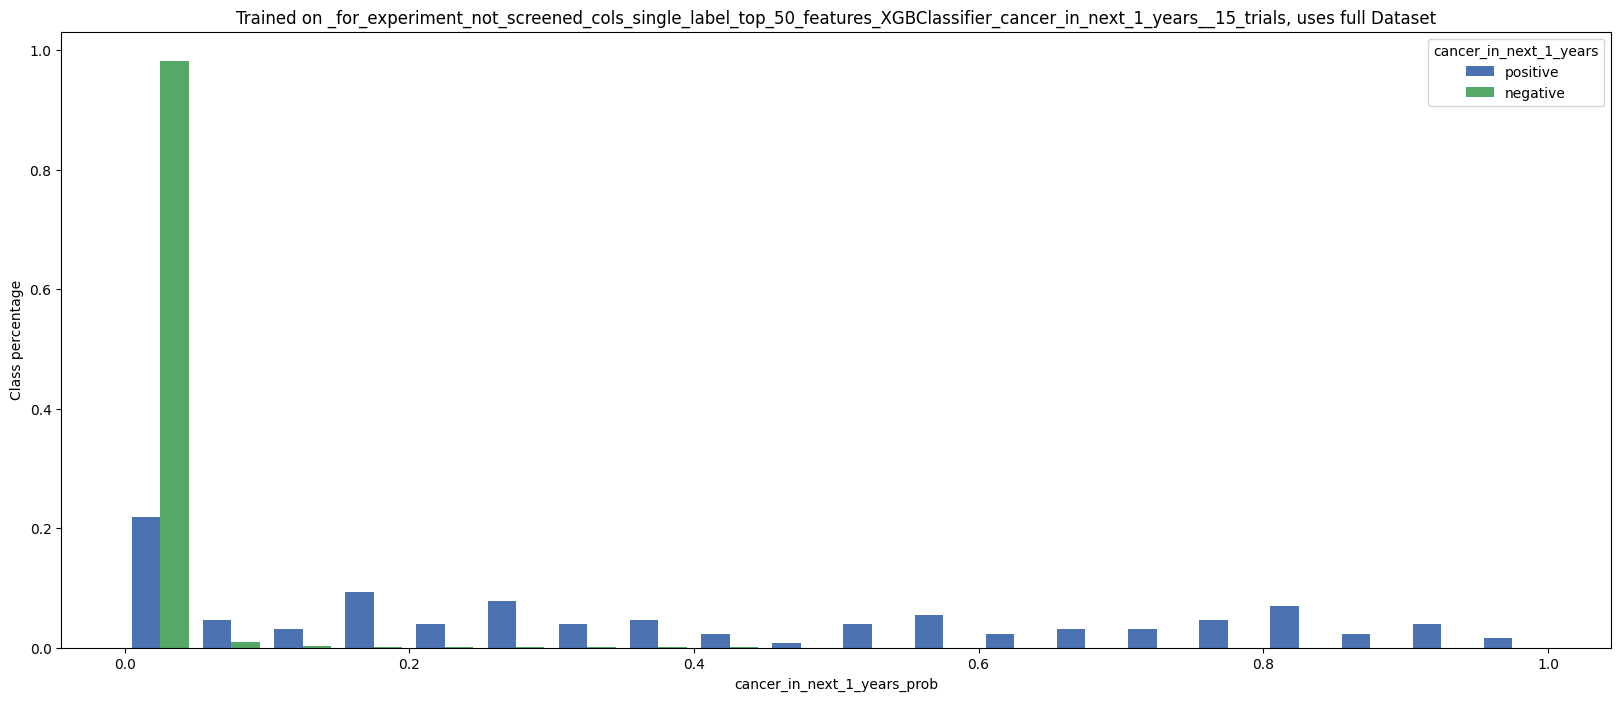

_for_experiment_not_screened_cols_single_label_top_50_features_RandomForestClassifier_cancer_in_next_1_years__15_trials: 
Threshold: 0.03876456876456877


Cross-Validation measures:
+--------------------+------------+-------------+----------+------------+
|                    |       mean |         std |      min |        max |
|--------------------+------------+-------------+----------+------------|
| precision__class_0 | 0.998724   | 4.16614e-05 | 0.998653 | 0.998777   |
| recall__class_0    | 0.954721   | 0.00339279  | 0.949228 | 0.96004    |
| f1-score__class_0  | 0.976224   | 0.00176175  | 0.97337  | 0.978966   |
| precision__class_1 | 0.00150335 | 0.000797423 | 0        | 0.00281096 |
| recall__class_1    | 0.0538618  | 0.0295192   | 0        | 0.097561   |
| f1-score__class_1  | 0.00292467 | 0.00155245  | 0        | 0.00546448 |
| accuracy           | 0.95356    | 0.00336091  | 0.948127 | 0.958799   |
| auc                | 0.551168   | 0.0611245   | 0.449553 | 0.656184   |
+---

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


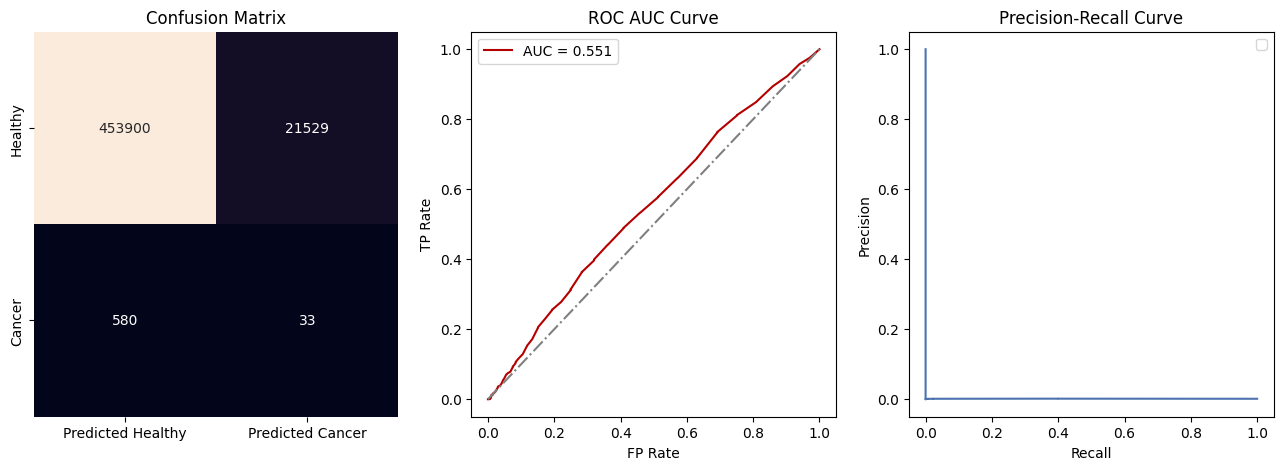

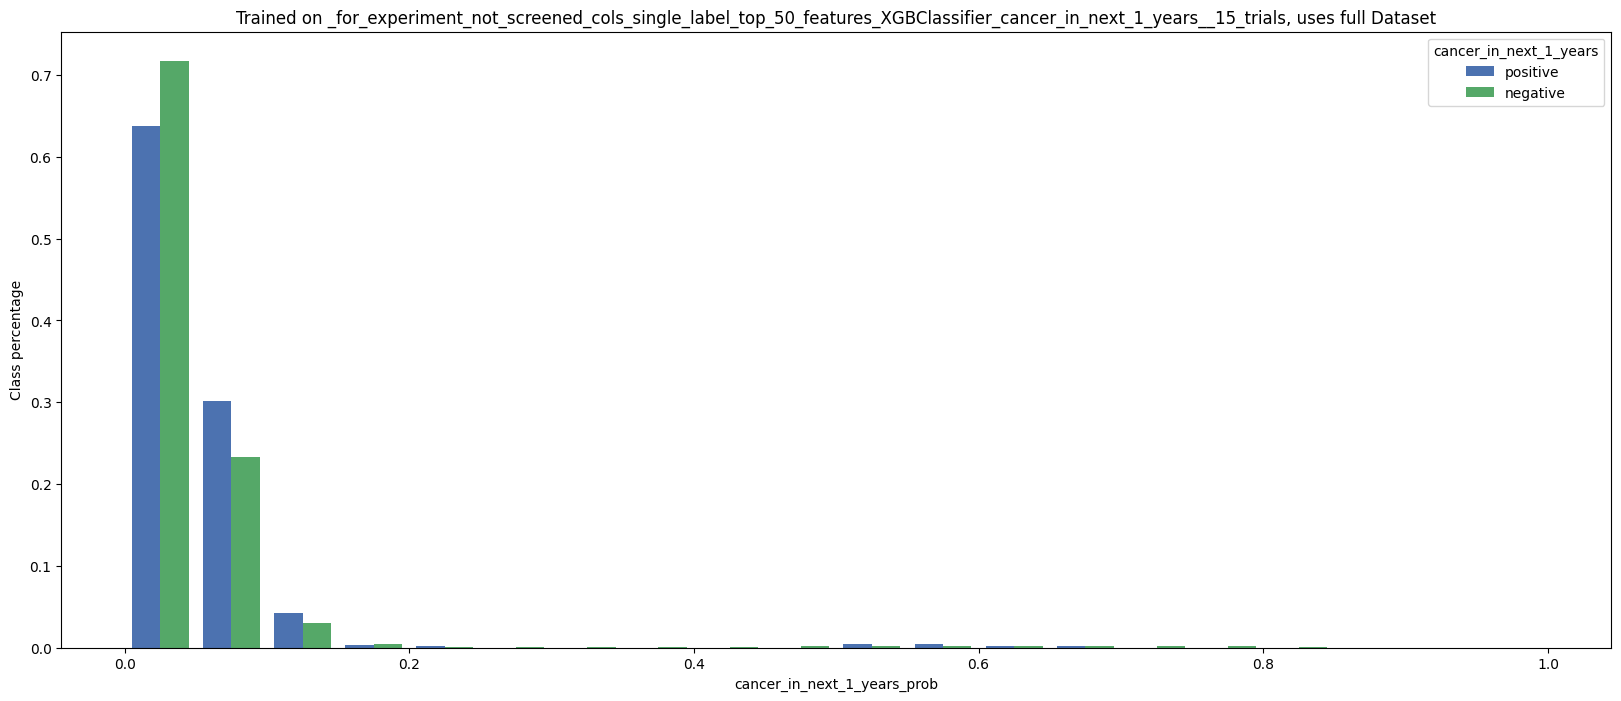

_for_experiment_participants_screened_single_first_5_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials: 
Threshold: 0.004071442410349846


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.999773  | 0.000125233 | 0.999466  | 0.99991   |
| recall__class_0    | 0.98776   | 0.00141003  | 0.985556  | 0.991141  |
| f1-score__class_0  | 0.99373   | 0.000682099 | 0.992636  | 0.995374  |
| precision__class_1 | 0.0416514 | 0.00892988  | 0.0252101 | 0.0597015 |
| recall__class_1    | 0.70463   | 0.159611    | 0.333333  | 0.888889  |
| f1-score__class_1  | 0.0785633 | 0.0166937   | 0.046875  | 0.111888  |
| accuracy           | 0.987545  | 0.00134676  | 0.985388  | 0.990794  |
| auc                | 0.9564    | 0.033736    | 0.891908  | 0.996869  |
+----------------

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


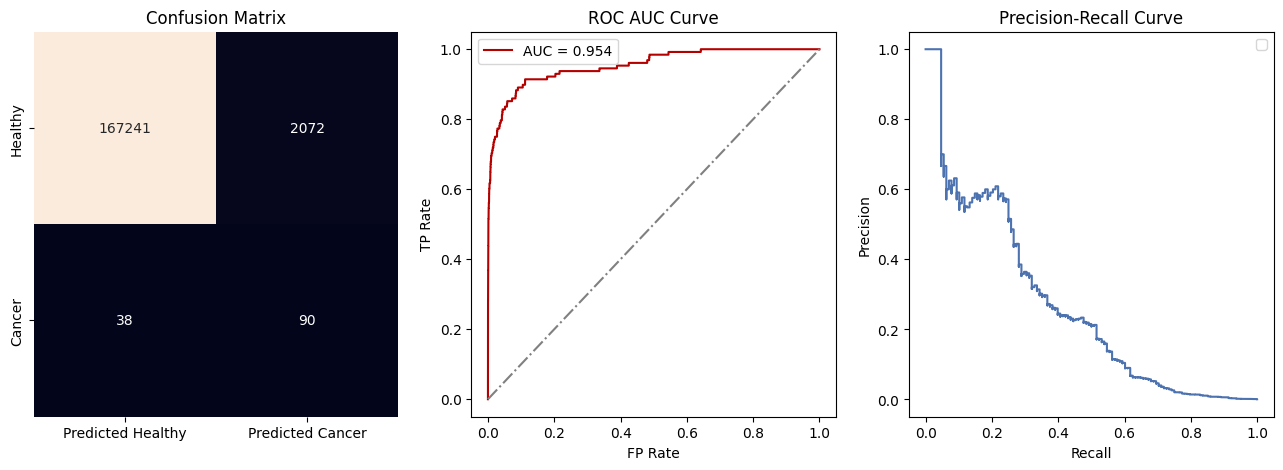

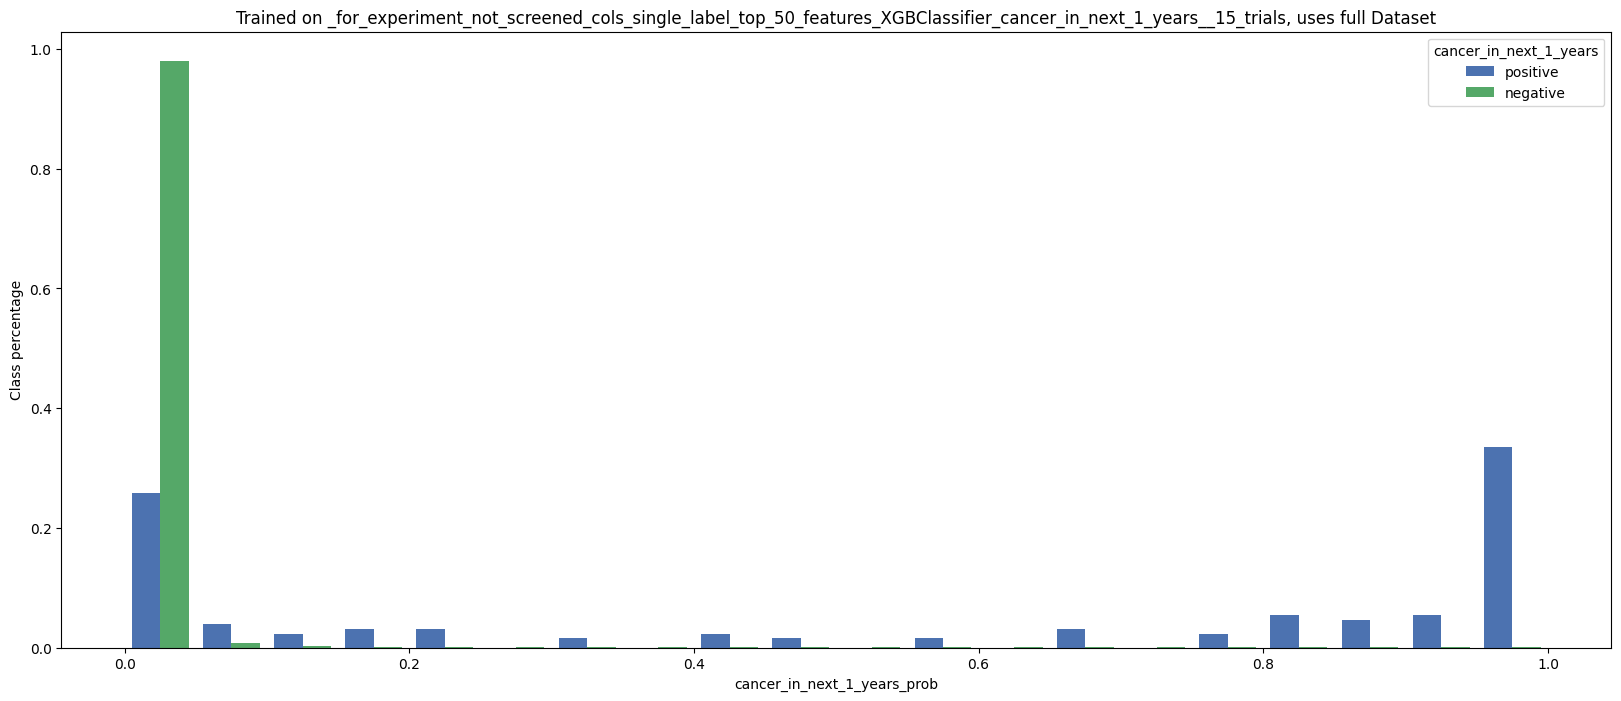

_for_experiment_not_screened_cols_single_label_top_50_features_XGBClassifier_cancer_in_next_1_years__15_trials: 
Threshold: 0.3243788778781891


Cross-Validation measures:
+--------------------+------------+-------------+------------+------------+
|                    |       mean |         std |        min |        max |
|--------------------+------------+-------------+------------+------------|
| precision__class_0 | 0.999199   | 0.000431682 | 0.998284   | 0.999749   |
| recall__class_0    | 0.245711   | 0.0128208   | 0.227885   | 0.267919   |
| f1-score__class_0  | 0.394268   | 0.016495    | 0.371145   | 0.422549   |
| precision__class_1 | 0.00144111 | 0.000142498 | 0.00110118 | 0.00163549 |
| recall__class_1    | 0.844715   | 0.0890753   | 0.65       | 0.95122    |
| f1-score__class_1  | 0.00287732 | 0.000284537 | 0.00219864 | 0.00326537 |
| accuracy           | 0.246483   | 0.0127315   | 0.228755   | 0.268649   |
| auc                | 0.585291   | 0.0787473   | 0.449998   | 0.687

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


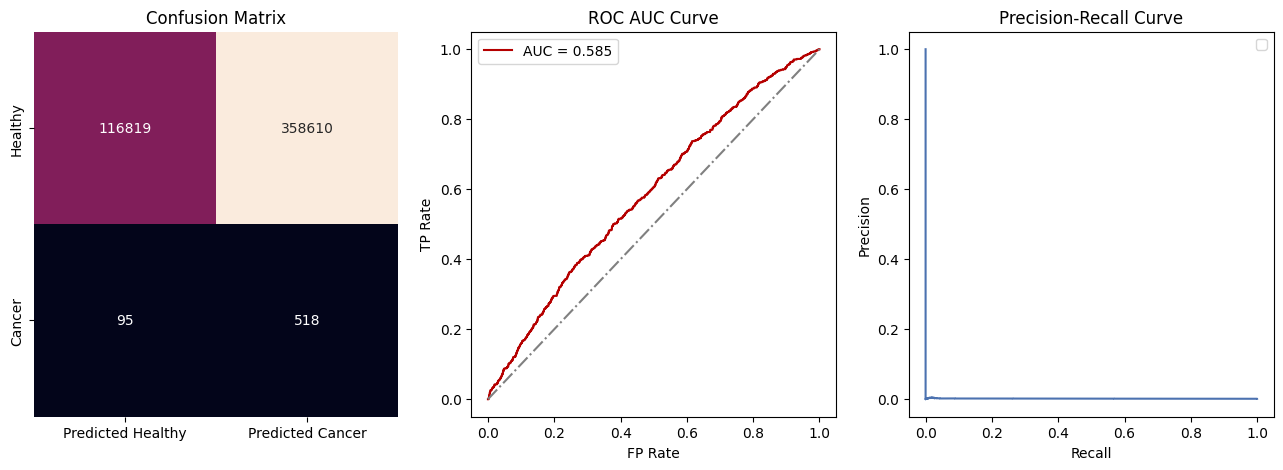

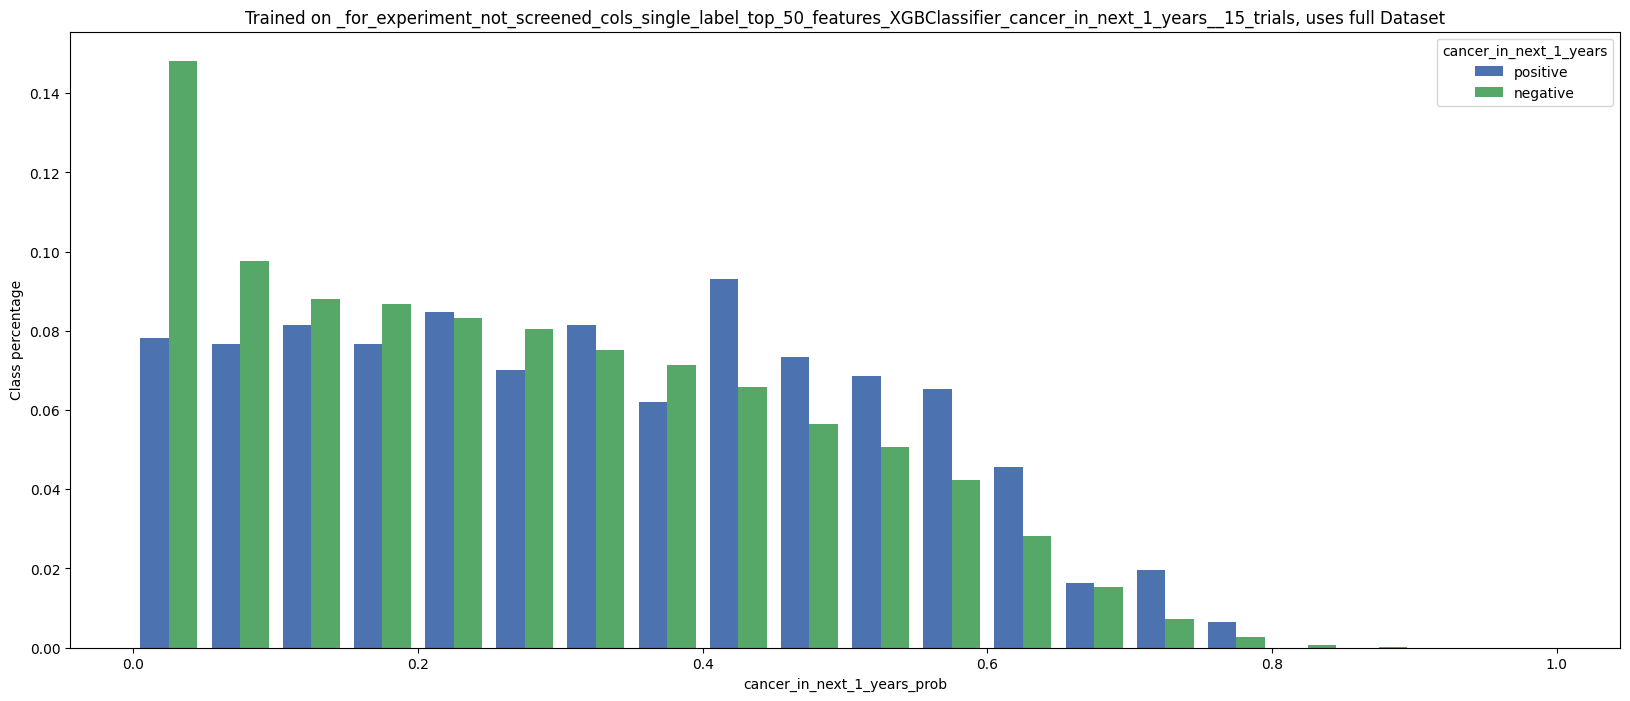

In [30]:
for key, cv_analytics_util in cv_analytics_utils.items():
    print(f"{key}: ")
    threshold = cv_analytics_util.get_optimal_operating_point()
    print(f"Threshold: {threshold}")
    cv_analytics_util.update_thresholds(0.1)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()
    label = cv_analytics_util.get_label()
    full_dataset = cv_analytics_util.get_dataset_with_predictions()
    plot_hist_side_by_side_for_class(full_dataset, label, f'{label}_prob', normalize = True, title=f'Trained on {filesuffix}, uses full Dataset')